In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models
from torchvision.transforms import Lambda
import medmnist
import copy
from medmnist import INFO, Evaluator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA

# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 下载并加载PneumoniaMNIST数据集
data_flag = 'pneumoniamnist'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# 数据增强和转换
train_transform = transforms.Compose([
    transforms.ToTensor(),
    Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[.5], std=[.5]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=train_transform, download=download)
val_dataset = DataClass(split='val', transform=test_transform, download=download)
test_dataset = DataClass(split='test', transform=test_transform, download=download)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# 加载预训练的ResNet模型并增加Dropout
model = models.resnet18(pretrained=True)

# 修改最后的全连接层以适应二分类任务（肺炎与非肺炎）
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 2)
)

# 将模型移动到GPU或CPU
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, criterion, optimizer, num_epochs=25, model_path='best_model.pth'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 每个epoch都有训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 训练模式
                dataloader = train_loader
            else:
                model.eval()   # 验证模式
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # 遍历数据
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device).squeeze().long()  # 确保labels是1D张量

                # 清零梯度
                optimizer.zero_grad()

                # 前向传播
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 反向传播 + 优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 深度复制模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, model_path)  # 保存最佳模型权重

    print(f'Best val Acc: {best_acc:4f}')

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model

# 训练模型
model = train_model(model, criterion, optimizer, num_epochs=25, model_path='best_model.pth')

Using downloaded and verified file: C:\Users\metho\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\metho\.medmnist\pneumoniamnist.npz
Using downloaded and verified file: C:\Users\metho\.medmnist\pneumoniamnist.npz


c:\Users\metho\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\metho\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 0.2379 Acc: 0.9112
val Loss: 0.2428 Acc: 0.9027
Epoch 1/24
----------
train Loss: 0.1444 Acc: 0.9433
val Loss: 0.4039 Acc: 0.8550
Epoch 2/24
----------
train Loss: 0.1290 Acc: 0.9486
val Loss: 0.2385 Acc: 0.8989
Epoch 3/24
----------
train Loss: 0.1196 Acc: 0.9507
val Loss: 0.0851 Acc: 0.9637
Epoch 4/24
----------
train Loss: 0.1250 Acc: 0.9511
val Loss: 0.1239 Acc: 0.9504
Epoch 5/24
----------
train Loss: 0.1052 Acc: 0.9620
val Loss: 0.0997 Acc: 0.9676
Epoch 6/24
----------
train Loss: 0.1090 Acc: 0.9588
val Loss: 0.2325 Acc: 0.9008
Epoch 7/24
----------
train Loss: 0.1097 Acc: 0.9565
val Loss: 0.1146 Acc: 0.9504
Epoch 8/24
----------
train Loss: 0.0986 Acc: 0.9669
val Loss: 0.2074 Acc: 0.9237
Epoch 9/24
----------
train Loss: 0.1008 Acc: 0.9596
val Loss: 0.1611 Acc: 0.9408
Epoch 10/24
----------
train Loss: 0.0920 Acc: 0.9641
val Loss: 0.0756 Acc: 0.9733
Epoch 11/24
----------
train Loss: 0.0963 Acc: 0.9624
val Loss: 0.1136 Acc: 0.9447
Epoch 12/24
--

Test Acc: 0.9071
Confusion Matrix:
[[180  54]
 [  4 386]]
Classification Report:
               precision    recall  f1-score   support

Non-Pneumonia     0.9783    0.7692    0.8612       234
    Pneumonia     0.8773    0.9897    0.9301       390

     accuracy                         0.9071       624
    macro avg     0.9278    0.8795    0.8957       624
 weighted avg     0.9151    0.9071    0.9043       624



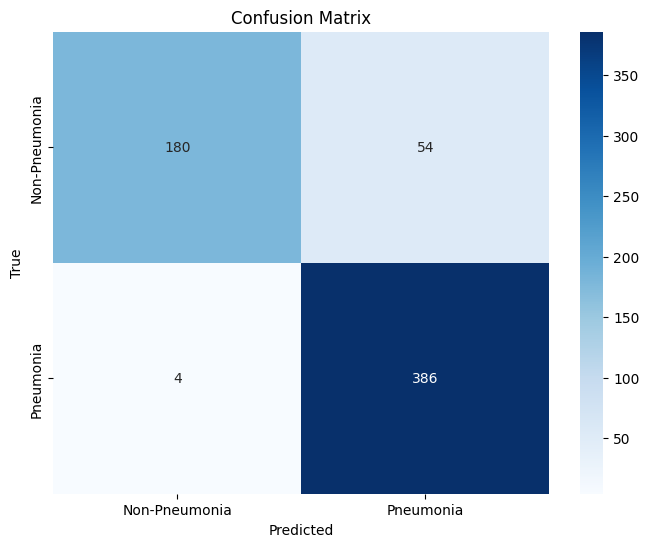

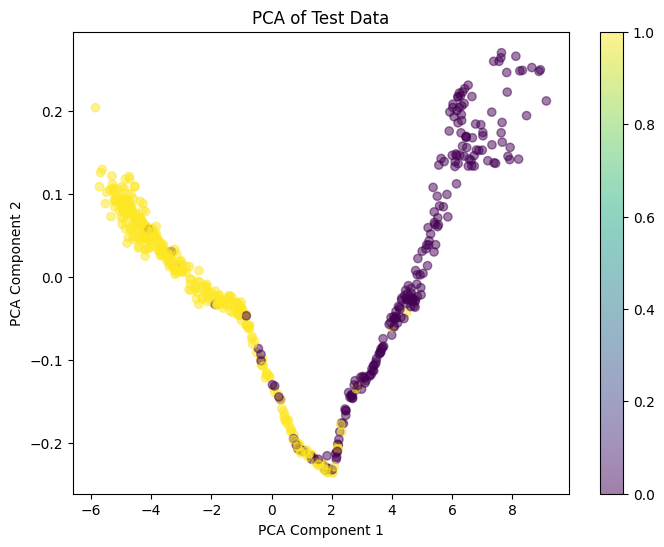

In [10]:
def test_model(model, test_loader, model_path='best_model.pth'):
    model.load_state_dict(torch.load(model_path))  # 加载最佳模型权重
    model.eval()  # 设定为评估模式
    running_corrects = 0
    all_labels = []
    all_preds = []
    all_features = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).long().squeeze()  # 确保labels是1D张量

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_features.extend(outputs.cpu().numpy())  # 获取特征输出

    acc = running_corrects.double() / len(test_loader.dataset)
    print(f'Test Acc: {acc:.4f}')

    # 生成混淆矩阵和分类报告
    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=['Non-Pneumonia', 'Pneumonia'], digits=4)
    
    print('Confusion Matrix:')
    print(cm)
    print('Classification Report:')
    print(cr)

    # 绘制混淆矩阵热力图
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Pneumonia', 'Pneumonia'], yticklabels=['Non-Pneumonia', 'Pneumonia'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # PCA降维
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(all_features)

    plt.figure(figsize=(8, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=all_labels, cmap='viridis', alpha=0.5)
    plt.colorbar()
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA of Test Data')
    plt.show()

# 测试模型
test_model(model, test_loader, model_path='best_model.pth')